In [1]:
import warnings
import pandas as pd
from pycaret.classification import *
from utils import create_w50_data, store_predictions

seed = 1
warnings.filterwarnings("ignore")

In [2]:
# Create Dataset for Week 50
data_w50 = create_w50_data()

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [3]:
# Load Training Data
df_training = pd.read_parquet("data/training_03.parquet")
df_training = df_training.sample(n=500_000, random_state=seed)
df_training.label.mean()

0.03151

In [4]:
# Define Numeric & Categorical Features
numeric_features = ['avg_n_transactions_weekly_customer', 'avg_spending_weekly',
       'highest_price_paid', 'lowest_price_paid',
       'sum_spending_last_week', 'n_transactions_last_week_customer',
       'current_price', 'avg_n_transactions_weekly_product',
       'avg_returns_weekly', 'sum_returns_last_week',
       'n_transactions_last_week_product', 'sum_returns_last_week_general',
       'moving_avg_returns_lm', 'sum_transactions_last_week_general',
       'moving_avg_transactions_lm', 'ratings'
]

categorical_features = [
    'pays_above_avg', 'costs_above_avg', 'within_budget'
]

In [5]:
# Preparing PyCaret
setup_params = {
    "target": "label",
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "silent": True,
    "fold" : 3,
    "session_id": seed,
    "preprocess": False,
    "remove_perfect_collinearity": False,
    "n_jobs": -1,
    "data": df_training
}

prep = setup(**setup_params)

,Description,Value
0,session_id,1
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(500000, 20)"
5,Missing Values,0
6,Numeric Features,16
7,Categorical Features,3
8,Transformed Train Set,"(349999, 19)"
9,Transformed Test Set,"(150001, 19)"


In [6]:
# Train & Compare some models
include = ["catboost", "nb"]

best_models = compare_models(
    sort="AUC",
    include=include, 
    n_select=len(include)
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9682,0.7613,0.0172,0.5113,0.0332,0.0312,0.0892,22.7333
nb,Naive Bayes,0.7422,0.7128,0.5307,0.0650,0.1157,0.0626,0.1120,1.3533


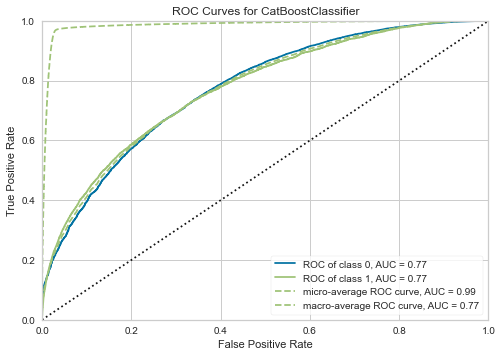

In [7]:
# Check Performance
plot_model(estimator=best_models[0], plot="auc")

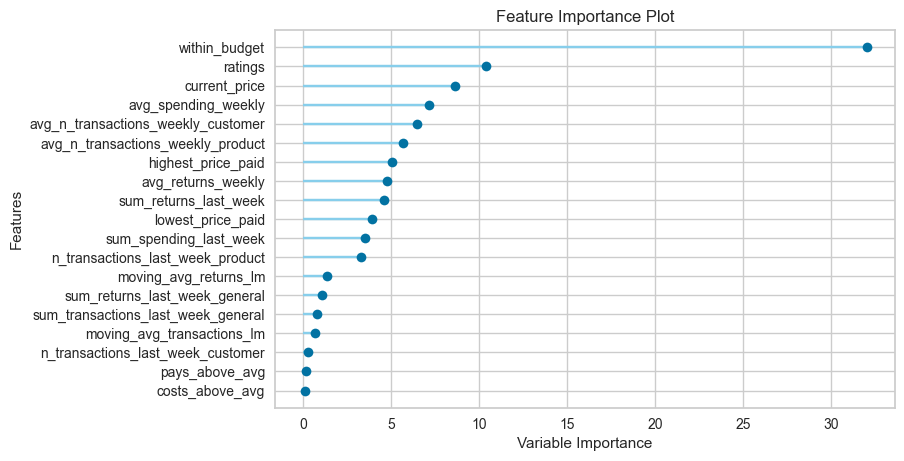

In [8]:
# Check Feature Importance
plot_model(estimator=best_models[0], plot="feature_all")

In [9]:
# Create & Store Predictions for Week 50
predictions = predict_model(
    estimator = best_models[0],
    data = data_w50[data_w50.columns[2:]],
    verbose=False,
    raw_score=True
    )["Score_1"]

store_predictions(data_week50=data_w50[["customer_id", "product_id"]], y_scores=predictions)
predictions.mean()

0.038082349499999994

In [10]:
# Load Resampled Data Set (random undersampling for negative class)
df_training_resampled = pd.read_parquet("data/training_03_resampled.parquet").sample(n=500_000, random_state=seed)
df_test = pd.read_parquet("data/test_03.parquet").sample(n=100_000, random_state=seed)

In [11]:
len(df_training_resampled), len(df_test)

(500000, 100000)

In [12]:
# Preparing PyCaret
setup_params = {
    "target": "label",
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "silent": True,
    "fold" : 3,
    "session_id": seed,
    "preprocess": False,
    "remove_perfect_collinearity": False,
    "n_jobs": -1,
    "test_data": df_test,
    "data": df_training_resampled
}

prep = setup(**setup_params)

,Description,Value
0,session_id,1
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(500000, 20)"
5,Missing Values,0
6,Numeric Features,16
7,Categorical Features,3
8,Transformed Train Set,"(500000, 19)"
9,Transformed Test Set,"(100000, 19)"


In [13]:
# Train & Compare some models with resampled data
best_models_resampled = compare_models(
    sort="AUC",
    include=include, 
    n_select=len(include)
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9140,0.7931,0.0946,0.6916,0.1665,0.1478,0.2345,19.1500
nb,Naive Bayes,0.6460,0.7114,0.6595,0.1563,0.2528,0.1242,0.1798,1.7467


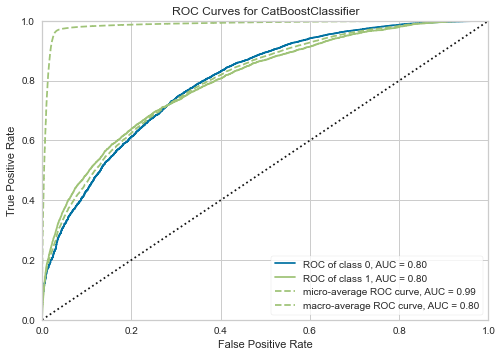

In [14]:
# Check Performance
plot_model(estimator=best_models_resampled[0], plot="auc")

In [15]:
df_test.label.mean()

0.03232

In [16]:
# Check for Bias
for name, model in zip(include, best_models_resampled):
    print(name,
        predict_model(
            estimator=model, 
            data=df_test[df_test.columns[1:]], 
            verbose=False, 
            raw_score=True
            )["Score_1"].mean())

catboost 0.08147407700000002
nb 0.40262255099999994


In [17]:
# Create & Store Predictions for Week 50 for model trained on resampled data
predictions = predict_model(
    estimator = best_models_resampled[0],
    data = data_w50[data_w50.columns[2:]],
    verbose=False,
    raw_score=True
    )["Score_1"]

store_predictions(
    data_week50=data_w50[["customer_id", "product_id"]], 
    y_scores=predictions,
    csv_name="output/delivery_resampled.csv"
    )